<a href="https://colab.research.google.com/github/Vic-key-os/CourseraLab/blob/main/MVP_Turnover%26PL_Dec23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import math
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import datetime
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


Mounted at /content/drive


<div class="alert alert-block alert-info">
<b>Загрузка всех файлов Excel</b>
</div>

In [2]:
pd.reset_option('display.max_rows')

## Загрузка данных из файла Excel
df_exchange_rates = pd.read_excel('/content/CT_Exchange_rates.xlsx')

mapping_df = pd.read_excel('/content/unique_clients_full_mapping.xlsx')

Col_names = pd.read_excel('/content/Column_names.xlsx')
column_names = Col_names.columns.tolist()

Balance_dict = pd.read_excel('/content/Balance_1-3w24.xlsx', sheet_name=None, skiprows=2, header=None, names=column_names)
Autotrx = pd.read_excel('/content/Dec23.xlsx')

<div class="alert alert-block alert-info">
<b>преобразование файла автоматических операций</b> - полный датафрейм: обороты и прибыль
</div>

In [3]:
# Используем переменную для отслеживания, когда был найден 'payout'
found_payout = False

# Перебираем строки DataFrame
for i in range(len(Autotrx)):
    # Проверяем, является ли текущее значение 'payout'
    if Autotrx.loc[i, 'Тип ордеру'] == 'payout':
        found_payout = True

    # Если значение является NaN
    if pd.isna(Autotrx.loc[i, 'Тип ордеру']):
        if found_payout:
            # Если 'payout' уже был найден, заменяем на 'payout'
            Autotrx.loc[i, 'Тип ордеру'] = 'payout'
        else:
            # Если 'payout' еще не найден, заменяем на 'payin'
            Autotrx.loc[i, 'Тип ордеру'] = 'payin'

Autotrx['Мерчант'] = Autotrx['Мерчант'].ffill()

Autotrx = Autotrx.loc[Autotrx['Profit'] != 0]
pd.options.display.float_format = '{:,.2f}'.format

In [4]:
def clean_merchant_name(name):
    # Удаление текста после слеша (если есть)
    if '/' in name:
        name = name.split('/')[0]

    # Удаление лишних пробелов
    name = name.strip()

    return name

# Применение функции очистки к колонке Merchant
Autotrx['Мерчант'] = Autotrx['Мерчант'].apply(clean_merchant_name)

In [5]:
# Autotrx

In [6]:
# Вычисление значений для нового столбца net_com_%
Autotrx['net_com_%'] = Autotrx['Комісія CrossPay%'] - Autotrx['Комісія supplier%']

# Получение списка названий столбцов
columns = list(Autotrx.columns)

# Находим индекс столбца 'Profit'
profit_index = columns.index('Profit')

# Вставляем новый столбец 'net_com_%' непосредственно перед 'Profit'
columns.remove('net_com_%')
columns.insert(profit_index, 'net_com_%')

# Применяем новый порядок столбцов к датафрейму
Autotrx = Autotrx[columns]



In [7]:
# Перестановка столбцов с индексами 0 и 1
columns[0], columns[1] = columns[1], columns[0]
Autotrx = Autotrx[columns]

# Определение столбцов для удаления (столбец с индексом 3 и столбцы с 5 по 9)
columns_to_drop = [columns[2]] + columns[5:9]

# Перестановка столбцов и удаление указанных столбцов
Autotrx_copy = Autotrx[columns].drop(columns_to_drop, axis=1).copy()


In [8]:
# Autotrx_copy

In [9]:
# Шаг 2: Создание словаря для соответствия имен клиентов
mapping_dict = dict(zip(mapping_df['Client Names'], mapping_df['map']))

# Шаг 3: Замена имен клиентов в датафрейме summed_profits
Autotrx_copy['Мерчант'] = Autotrx_copy['Мерчант'].map(mapping_dict).fillna(Autotrx_copy['Мерчант'])

In [10]:
summed_profits = Autotrx_copy.groupby(['Мерчант', 'Тип ордеру', 'Валюта'])['Profit'].sum().reset_index()

In [11]:
# summed_profits

In [12]:
# Переименование столбцов
Autotrx_copy = Autotrx_copy.rename(columns={
    'Мерчант': 'client',
    'Тип ордеру': 'order_type',
    'Валюта': 'currency',
    'Profit': 'comis_profit',
    'Оборот': 'turnover'
})
# Определение индекса столбца 'Merchant'
merchant_index = Autotrx_copy.columns.get_loc('client') + 1

# Вставка нового столбца 'Operation_type' со значением 'auto' после 'Merchant'
Autotrx_copy.insert(merchant_index, 'operation_type', 'auto')

# Определение индекса столбца comis_profit
comis_profit_index = Autotrx_copy.columns.get_loc('comis_profit') + 1

# Вставка столбца exch_prof со значением 0 после comis_profit
Autotrx_copy.insert(comis_profit_index, 'exch_prof', 0)


In [13]:
Autotrx_copy

,client,operation_type,order_type,currency,turnover,net_com_%,comis_profit,exch_prof
0,1Cas,auto,payin,uah,"59,394,489.00",0.01,"475,155.94",0
1,LotoClub,auto,payin,kzt,"10,015,719.00",0.01,"137,287.05",0
2,LotoClub,auto,payin,usd,408.56,0.01,4.23,0
3,LotoClub,auto,payin,kzt,"1,394,417,187.00",0.02,"32,709,144.51",0
4,alex_po,auto,payin,uah,"1,000.00",0.01,8.00,0
...,...,...,...,...,...,...,...,...
161,V4game_ecom(p2p),auto,payout,uah,"4,400.00",0.02,88.00,0
162,V4game_ecom(p2p),auto,payout,uah,"4,800.00",0.01,33.60,0
163,Guk,auto,payout,uah,"260,000.00",-0.02,"-5,980.00",0
166,WhitStudio,auto,payout,uah,"99,972.00",-0.02,"-2,299.43",0


In [14]:
# Группировка данных по 'Мерчант', 'Тип ордеру', 'Валюта' и суммирование значений в столбцах turnover и Profit
summed_values = Autotrx_copy.groupby(['client', 'operation_type', 'order_type', 'currency']).agg({'turnover': 'sum', 'comis_profit': 'sum'}).reset_index()
summed_values['exch_prof'] = 0


In [15]:
summed_values

,client,operation_type,order_type,currency,turnover,comis_profit,exch_prof
0,1Cas,auto,payin,uah,"59,394,489.00","475,155.94",0
1,1Cas,auto,payout,uah,"1,916,622.83","24,917.37",0
2,7Pay,auto,payout,kzt,"219,939,422.48","-3,785,458.17",0
3,7Pay,auto,payout,uah,"7,133,995.21","-163,889.14",0
4,ABEX,auto,payout,uah,"2,981,120.96","-68,565.88",0
...,...,...,...,...,...,...,...
65,Аня Шалай,auto,payout,uah,"67,100.00","-1,543.30",0
66,ГРОУ,auto,payout,uah,"3,118,720.00","-71,730.67",0
67,Маруся,auto,payout,uah,"49,880.00","-1,147.24",0
68,Мирослав Биков,auto,payout,uah,"199,387.00","-4,585.93",0


<div class="alert alert-block alert-success">
датафрейм <b>summed_values</b> готов для склеивания с файлом ручных операций
</div>


In [16]:
pd.set_option('display.max_rows', None)
# summed_values

In [17]:
# pd.set_option('display.max_rows', None)
pd.reset_option('display.max_rows')

<div class="alert alert-block alert-info">
<b>преобразование файла ручных операций</b>
</div>

In [18]:
# Переопределим код очистки DataFrame'ов, чтобы избежать удаления строк, где дата валидна

cleaned_sheets_dict = {}  # Создаем новый словарь для хранения обработанных DataFrame'ов

for sheet_name, df in Balance_dict.items():
    # Преобразуем даты с применением errors='coerce', чтобы невалидные даты стали NaT
    df['date_converted'] = pd.to_datetime(df['date'], errors='coerce')

    # Находим последнюю ненулевую дату во второй колонке
    last_valid_index = df['date_converted'].last_valid_index()

    # Если такая дата найдена, обрезаем DataFrame до этой строки включительно
    if last_valid_index is not None:
        cleaned_df = df.loc[:last_valid_index]
    else:
        cleaned_df = df  # Если в колонке нет дат, оставляем DataFrame как есть

    # Удаляем временную колонку 'date_converted'
    cleaned_df = cleaned_df.drop(columns=['date_converted'])

    # Добавляем обработанный DataFrame в новый словарь
    cleaned_sheets_dict[sheet_name] = cleaned_df

# Объединяем все DataFrame'ы из словаря в один DataFrame
combined_df = pd.concat(cleaned_sheets_dict.values(), ignore_index=True)

# Создаем словарь замен
replacements = {
    'KZT': 'kzt',
    'КЗТ': 'kzt',
    'Uah Б': 'uah',
    'uah БН': 'uah',
    'uah Б': 'uah',
    'eur БН': 'eur'
}

# Применяем замены к столбцам 'sell_cur' и 'buy_cur'
combined_df['sell_cur'] = combined_df['sell_cur'].replace(replacements, regex=True)
combined_df['buy_cur'] = combined_df['buy_cur'].replace(replacements, regex=True)

# Убедимся, что колонка 'date' преобразована в datetime
combined_df['date'] = pd.to_datetime(combined_df['date'], errors='coerce')

In [19]:
# combined_df

<div class="alert alert-block alert-warning">
выбор <b>периода для анализа</b> в файле Balance - должен совпадать с периодом выгруженным из Tableau (auto operations) для корректности анализа
</div>

In [20]:
start_date = '2023-12-01'
end_date = '2023-12-31'
df_2024 = combined_df[(combined_df['date'] >= start_date) & (combined_df['date'] <= end_date)].copy()

In [21]:
# Теперь заменяем NaN на 0 в определенных колонках
df_2024.loc[:, df_2024.columns[6:11]] = df_2024.loc[:, df_2024.columns[6:11]].fillna(0)
df_2024_input = df_2024.iloc[:, :-7].copy()

<div class="alert alert-block alert-info">
далее копия среза за период для преобразования и манипуляций - df_2024_input
</div>


In [22]:
df_2024_input

,date,owner,sell_cur,client,buy_cur,received_buy_cur,%_com,exch_r1,exch_r2,cost_%
538,2023-12-06,CrossP,usdt,WhitExchange,kzt,"4,700,000.00",0.00,480.00,0.00,0.00
539,2023-12-08,CrossP,usdt,Leo,usdt,"7,035,000.00",0.00,469.00,0.00,0.00
540,2023-12-12,CrossP,usdt,Leo,usdt,"7,567,000.00",0.00,470.00,0.00,0.00
541,2023-12-01,CrossP,kzt,7Pay,usdt,"20,000,000.00",0.00,469.00,503.00,0.00
542,2023-12-03,CrossP,kzt,7Pay,usdt,"20,000,000.00",0.00,469.00,503.00,0.00
...,...,...,...,...,...,...,...,...,...,...
759,2023-12-21,CrossP,usd,Pion,usdt,"24,737.69",2.00,1.00,0.00,0.00
760,2023-12-29,CrossP,usd,Pion,usdt,"9,716.43",2.00,1.00,0.00,0.00
761,2023-12-07,NaN,eur,Pion,usdt,776.25,1.00,0.93,0.00,0.00
762,2023-12-21,NaN,eur,Pion,usdt,53.75,1.00,0.92,0.00,0.00


In [23]:
df_2024_input['usd_eqv'] = df_2024_input['received_buy_cur'] / df_2024_input['exch_r1']
pd.options.display.float_format = '{:,.2f}'.format

In [24]:
# Модифицированная функция для расчета баланса с учетом деления на ноль
def calculate_balance(row):
    # Проверка на ноль в 'exch_r1'
    if row['exch_r1'] == 0 and row['sell_cur'] in ['usd', 'eur']:
        return None  # Или другое специфическое значение для обработки этого случая

    if row['sell_cur'] in ['kzt', 'uah']:
        return row['received_buy_cur'] - row['received_buy_cur'] * row['%_com'] / 100
    elif row['sell_cur'] in ['usd', 'eur']:
        return (row['received_buy_cur'] - row['received_buy_cur'] * row['%_com'] / 100) / row['exch_r1']
    elif row['sell_cur'] == 'usdt':
        if row['buy_cur'] in ['kzt', 'uah']:
            return row['received_buy_cur'] / (1 - row['%_com']/100)
        elif row['buy_cur'] == 'usd':
            return row['received_buy_cur'] - row['received_buy_cur'] * row['%_com'] / 100 - 100
    return None

# Применяем модифицированную функцию к каждой строке датафрейма
df_2024_input['balance'] = df_2024_input.apply(calculate_balance, axis=1)

<div class="alert alert-block alert-warning">
<b>сверка с расчетами Стата по полю 'balance':</b>
</div>

In [25]:
balance_index = df_2024.columns.get_loc('balance') + 1

# Вставляем колонку 'balance_calc' непосредственно после колонки 'balance'
df_2024.insert(balance_index, 'balance_calc', df_2024_input['balance'])

df_2024['balance_calc'] = df_2024_input['balance']

# Находим строки, где значения 'balance' не совпадают
mismatch_rows = df_2024[df_2024['balance'] != df_2024['balance_calc']]


In [26]:
# Результат
# mismatch_rows

In [27]:
# Функция для расчета comis_profit
def calculate_comis_profit(row):
    if row['buy_cur'] in ['kzt', 'uah'] and row['sell_cur'] == 'usdt':
        return row['balance'] - row['received_buy_cur']
    elif row['sell_cur'] in ['kzt', 'uah'] and row['buy_cur'] in ['usdt', 'uah']:
        return row['received_buy_cur'] - row['balance']
    elif row['buy_cur'] == 'usd':
        return row['received_buy_cur'] - row['balance']
    elif row['sell_cur'] == 'usd' and row['buy_cur'] == 'usdt':
        return row['balance'] - row['received_buy_cur']
    elif row['sell_cur'] == 'eur' and row['buy_cur'] == 'usdt':
        return row['received_buy_cur'] * row['%_com'] * (-1) / 100
    return None

# Применяем функцию к каждой строке датафрейма
df_2024_input['comis_profit'] = df_2024_input.apply(calculate_comis_profit, axis=1)

def calculate_exch_prof(row):
    if row['exch_r2'] == 0:
        return 0
    else:
        return row['usd_eqv'] * row['exch_r2'] - row['received_buy_cur']

# Применяем функцию к каждой строке датафрейма
df_2024_input['exch_prof'] = df_2024_input.apply(calculate_exch_prof, axis=1)

df_2024_input['tot_prof'] = df_2024_input['exch_prof'] + df_2024_input['comis_profit']

In [28]:
# df_2024_input

<div class="alert alert-block alert-danger">
<b>сверка с расчетами Стаса - общая прибыль ("Prof")</b>
</div>

In [29]:
balance_index_1 = df_2024.columns.get_loc('profit') + 1

# Вставляем колонку 'balance_calc' непосредственно после колонки 'balance'
df_2024.insert(balance_index_1, 'tot_prof', df_2024_input['tot_prof'])

df_2024['tot_prof'] = df_2024_input['tot_prof']

# Находим строки, где значения 'balance' не совпадают
mismatch_rows_1 = df_2024[df_2024['profit'] != df_2024['tot_prof']]

In [30]:
# Результат
pd.set_option('display.max_rows', None)
mismatch_rows_1

,date,owner,sell_cur,client,buy_cur,received_buy_cur,%_com,exch_r1,exch_r2,cost_%,usd_eqv,balance,balance_calc,costs,profit,tot_prof,exr_profit,other1,other2
539,2023-12-08,CrossP,usdt,Leo,usdt,"7,035,000.00",0.00,469.00,0.00,0.00,"15,000.00","7,035,000.00",NaN,0.00,0.00,NaN,NaN,NaN,NaN
540,2023-12-12,CrossP,usdt,Leo,usdt,"7,567,000.00",0.00,470.00,0.00,0.00,"16,100.00","7,567,000.00",NaN,0.00,0.00,NaN,NaN,NaN,NaN
587,2023-12-13,CrossP,NaN,NaN,uah,NaN,0.00,0.00,0.00,0.00,0.00,0.00,NaN,0.00,"74,350.00",NaN,Профит от 11.2023,"74,350.00",NaN
588,2023-12-13,CrossP,NaN,NaN,usdt,NaN,0.00,38.00,0.00,0.00,0.00,0.00,NaN,0.00,"445,360.00",NaN,Слава за соседа,"445,360.00",NaN
628,2023-12-29,CrossP,usdt,Cosmo,uah,"3,940,000.00",1.50,40.00,0.00,0.00,"98,500.00","4,000,000.00","4,000,000.00",0.00,"219,545.91","60,000.00",профит по ручным выплатам,"159,545.91",NaN
632,2023-12-01,NaN,NaN,Cross,uah,"200,000.00",0.00,0.00,0.00,0.00,0.00,"200,000.00",NaN,0.00,0.00,NaN,NaN,200к грн Стасу на баланс,NaN
636,2023-12-01,NaN,NaN,Cross,uah,NaN,0.00,0.00,0.00,0.00,0.00,0.00,NaN,0.00,0.00,NaN,NaN,50к usdt Стасу на баланс,NaN
637,2023-12-01,CrossP,uah,Guk,uah,"612,244.89",2.00,37.30,38.20,0.00,"16,414.07","599,999.99","599,999.99",0.00,"12,244.90","27,017.56",NaN,NaN,NaN
638,2023-12-01,NaN,NaN,Cross,uah,"10,000.00",0.00,0.00,0.00,0.00,0.00,"10,000.00",NaN,0.00,0.00,NaN,NaN,10к грн Ане на баланс,NaN
641,2023-12-04,NaN,NaN,Cross,uah,NaN,0.00,0.00,0.00,0.00,0.00,0.00,NaN,0.00,0.00,NaN,NaN,150к usdt Стасу на баланс,NaN


<div class="alert alert-block alert-info">
подготовка файла Балансы для склеивания с автоматическими операциями
</div>

In [31]:
# Функция для определения значения в новой колонке order_type
def define_order_type(row):
    if row['sell_cur'] in ['kzt', 'eur', 'usd']:
        return 'payout'
    elif row['sell_cur'] == 'uah':
        return 'payout' if row['client'] != 'CMGW' else 'payin'
    return 'payin'

# Добавляем колонку 'order_type' в конец датафрейма
df_2024_input['order_type'] = df_2024_input.apply(define_order_type, axis=1)

# Находим индекс колонки 'date' и добавляем 1, чтобы вставить 'order_type' после нее
date_index = df_2024_input.columns.get_loc('date') + 1

# Перемещаем 'order_type' на нужное место
order_type = df_2024_input.pop('order_type')
df_2024_input.insert(date_index, 'order_type', order_type)

In [32]:
result_df = df_2024_input.drop(['owner', 'cost_%'], axis=1).copy()

In [33]:
clean_2024 = result_df.drop(result_df.columns[6:11], axis=1).copy()

In [34]:
# Определение индекса столбца 'Merchant'
merchant_index_2 = clean_2024.columns.get_loc('client') + 1

# Вставка нового столбца 'Operation_type' со значением 'auto' после 'Merchant'
clean_2024.insert(merchant_index_2, 'operation_type', 'manual')

In [35]:


# Шаг 2: Перемещение столбца order_type после Operation_type
# Получаем список названий столбцов
column_names = list(clean_2024.columns)
# Удаляем 'order_type' из списка и вставляем его на новое место
column_names.remove('order_type')
operation_type_index = column_names.index('operation_type') + 1
column_names.insert(operation_type_index, 'order_type')

# Применяем новый порядок столбцов к датафрейму
clean_2024 = clean_2024[column_names]

# Шаг 3: Создание новой колонки currency
clean_2024['currency'] = clean_2024.apply(
    lambda row: row['buy_cur'] if row['order_type'] == 'payin' else row['sell_cur'],
    axis=1
).copy()

# Перемещаем 'currency' после 'order_type'
currency_col = clean_2024.pop('currency')
order_type_index = clean_2024.columns.get_loc('order_type') + 1
clean_2024.insert(order_type_index, 'currency', currency_col)
clean_2024.fillna(0, inplace=True)


<ipython-input-35-ea16291d80c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_2024['currency'] = clean_2024.apply(


In [36]:
df_to_merge_clean_2024 = clean_2024.drop(['date', 'sell_cur', 'buy_cur', 'tot_prof'], axis=1).copy()
df_to_merge_clean_2024.rename(columns={'received_buy_cur': 'turnover'}, inplace=True)

In [37]:
# summed_values

<div class="alert alert-block alert-info">
склеивание двух датафреймов
</div>

In [38]:
full_merged = pd.concat([df_to_merge_clean_2024, summed_values], ignore_index=True)

<div class="alert alert-block alert-success">
результирующий датафрейм для последующего анализа
</div>

In [39]:
pd.set_option('display.max_rows', None)
# pd.reset_option('display.max_rows')
full_merged

,client,operation_type,order_type,currency,turnover,comis_profit,exch_prof
0,WhitExchange,manual,payin,kzt,"4,700,000.00",0.00,0.00
1,Leo,manual,payin,usdt,"7,035,000.00",0.00,0.00
2,Leo,manual,payin,usdt,"7,567,000.00",0.00,0.00
3,7Pay,manual,payout,kzt,"20,000,000.00",0.00,"1,449,893.39"
4,7Pay,manual,payout,kzt,"20,000,000.00",0.00,"1,449,893.39"
5,7Pay,manual,payout,kzt,"10,000,000.00",0.00,"724,946.70"
6,7Pay,manual,payout,kzt,"10,000,000.00",0.00,"724,946.70"
7,7Pay,manual,payout,kzt,"20,000,000.00",0.00,"1,063,829.79"
8,7Pay,manual,payout,kzt,"20,000,000.00",0.00,"1,063,829.79"
9,7Pay,manual,payout,kzt,"20,000,000.00",0.00,"1,449,893.39"


In [40]:
# Группировка и суммирование значений в столбцах comis_profit и exch_prof
total_summed_values = full_merged.groupby(['client', 'operation_type', 'order_type', 'currency'])[['turnover', 'comis_profit', 'exch_prof']].sum().reset_index()
new_df = total_summed_values.iloc[2:].reset_index(drop=True)

In [41]:
new_df['tot_prof'] = new_df['comis_profit'] + new_df['exch_prof']

In [42]:
# Создание словаря из DataFrame обменных курсов
exchange_rates_dict = df_exchange_rates.set_index('Currency')['USD'].to_dict()

# Функция для конвертации значения tot_prof и turnover в USD
def convert_to_usd(row, column_name):
    currency = row['currency']
    amount = row[column_name]
    exchange_rate = exchange_rates_dict.get(currency, 1)  # Берем курс валюты, если он есть, иначе используем 1
    return amount / exchange_rate

# Применение функции к tot_prof и turnover
new_df['turnover_in_usd'] = new_df.apply(lambda row: convert_to_usd(row, 'turnover'), axis=1)
new_df['profit_in_USD'] = new_df.apply(lambda row: convert_to_usd(row, 'tot_prof'), axis=1)

# Перестановка столбцов для размещения turnover_in_usd слева от Profit_in_USD
cols = new_df.columns.tolist()
turnover_index = cols.index('profit_in_USD')
cols.insert(turnover_index, cols.pop(cols.index('turnover_in_usd')))
new_df = new_df[cols]


In [43]:
new_df

,client,operation_type,order_type,currency,turnover,comis_profit,exch_prof,tot_prof,profit_in_USD,turnover_in_usd
0,1Cas,auto,payin,uah,"59,394,489.00","475,155.94",0.00,"475,155.94","12,341.71","1,542,714.00"
1,1Cas,auto,payout,uah,"1,916,622.83","24,917.37",0.00,"24,917.37",647.20,"49,782.41"
2,1Cas,manual,payin,uah,"45,810,375.00","1,174,625.00",0.00,"1,174,625.00","30,509.74","1,189,879.87"
3,7Pay,auto,payout,kzt,"219,939,422.48","-3,785,458.17",0.00,"-3,785,458.17","-8,375.65","486,634.71"
4,7Pay,auto,payout,uah,"7,133,995.21","-163,889.14",0.00,"-163,889.14","-4,256.86","185,298.58"
5,7Pay,manual,payout,kzt,"210,000,000.00",0.00,"13,292,736.56","13,292,736.56","29,411.31","464,642.89"
6,7Pay,manual,payout,uah,"7,500,000.00",0.00,"91,844.20","91,844.20","2,385.56","194,805.19"
7,ABEX,auto,payout,uah,"2,981,120.96","-68,565.88",0.00,"-68,565.88","-1,780.93","77,431.71"
8,ABEX,manual,payout,uah,"3,327,050.00",0.00,"53,220.00","53,220.00","1,382.34","86,416.88"
9,Antonov,auto,payout,uah,"473,840.20","-10,898.33",0.00,"-10,898.33",-283.07,"12,307.54"


In [44]:
# Группировка по клиентам для расчета оборота и прибыли
turnover_pin = new_df[new_df['order_type'] == 'payin'].groupby('client')['turnover_in_usd'].sum().reset_index(name='turnover_pin_usd')
turnover_pout = new_df[new_df['order_type'] == 'payout'].groupby('client')['turnover_in_usd'].sum().reset_index(name='turnover_pout_usd')
total_profit_per_client = new_df.groupby('client')['profit_in_USD'].sum().reset_index(name='tot_profit_in_usd')

# Объединение результатов
combined_results = total_profit_per_client.merge(turnover_pin, on='client', how='left').merge(turnover_pout, on='client', how='left')

# Расчет общих сумм для оборота и прибыли
total_turnover_pin = turnover_pin['turnover_pin_usd'].sum()
total_turnover_pout = turnover_pout['turnover_pout_usd'].sum()
total_profit = total_profit_per_client['tot_profit_in_usd'].sum()

# Добавление строки с общими суммами в начало датафрейма
total_row = pd.DataFrame([['Total', total_turnover_pin, total_turnover_pout, total_profit]],
                         columns=['client', 'turnover_pin_usd', 'turnover_pout_usd', 'tot_profit_in_usd'])
combined_results = pd.concat([total_row, combined_results], ignore_index=True)

In [45]:
combined_results

,client,turnover_pin_usd,turnover_pout_usd,tot_profit_in_usd
0,Total,"26,917,540.49","12,995,080.75","308,447.60"
1,1Cas,"2,732,593.87","49,782.41","43,498.66"
2,7Pay,NaN,"1,331,381.37","19,164.37"
3,ABEX,NaN,"163,848.60",-398.59
4,Antonov,NaN,"22,333.51",-103.12
5,Binance,"434,363.82",NaN,0.00
6,Buki,NaN,258.89,8.18
7,CMGW,"324,010.72",NaN,0.00
8,Capa,NaN,"3,114,893.65","25,199.48"
9,CashLink,"97,726.75",NaN,0.00


In [46]:
# Удаление строки с общими суммами для сортировки
sorted_results = combined_results.drop(0)

# Сортировка по убыванию значения tot_profit_in_usd
sorted_results = sorted_results.sort_values(by='tot_profit_in_usd', ascending=False)

# Повторное добавление строки с общими суммами в начало датафрейма
sorted_results = pd.concat([total_row, sorted_results], ignore_index=True)


In [47]:
sorted_results

,client,turnover_pin_usd,turnover_pout_usd,tot_profit_in_usd
0,Total,"26,917,540.49","12,995,080.75","308,447.60"
1,LotoClub,"3,107,836.00","2,365,288.93","105,928.42"
2,Trasty,"42,629.96","2,803,208.44","48,494.40"
3,1Cas,"2,732,593.87","49,782.41","43,498.66"
4,Cosmo,"3,367,581.22","642,656.96","28,739.69"
5,Capa,NaN,"3,114,893.65","25,199.48"
6,SlotSity,"1,449,933.90","483,094.07","20,073.60"
7,7Pay,NaN,"1,331,381.37","19,164.37"
8,Godza,NaN,"397,868.65","4,579.63"
9,Pyla,NaN,"174,131.46","3,336.56"


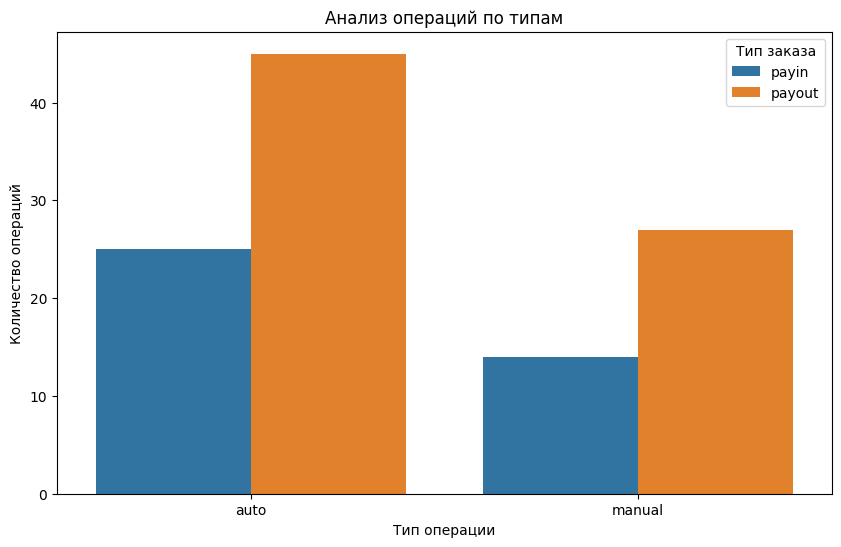

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Подготовка данных для анализа
operation_counts = new_df.groupby(['operation_type', 'order_type']).size().reset_index(name='count')

# Визуализация данных
plt.figure(figsize=(10, 6))
sns.barplot(x='operation_type', y='count', hue='order_type', data=operation_counts)
plt.title('Анализ операций по типам')
plt.xlabel('Тип операции')
plt.ylabel('Количество операций')
plt.legend(title='Тип заказа')
plt.show()


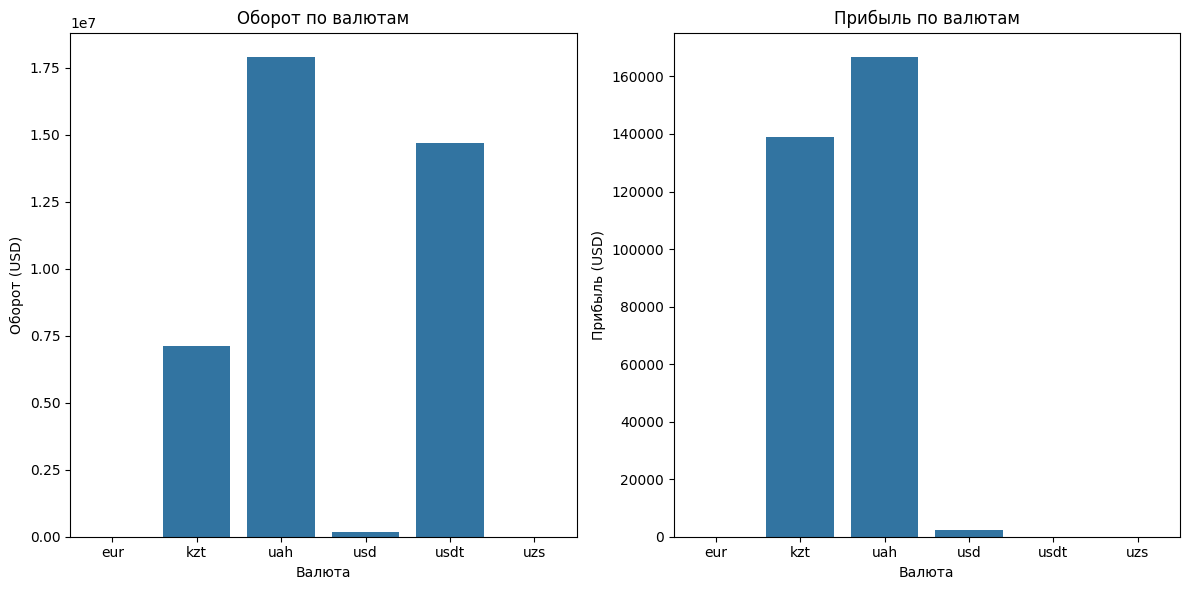

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Группировка данных по валюте и расчет сумм для оборота и прибыли
currency_analysis = new_df.groupby('currency').agg({'turnover_in_usd': 'sum', 'profit_in_USD': 'sum'}).reset_index()

# Визуализация данных
plt.figure(figsize=(12, 6))

# Столбчатая диаграмма для оборота
plt.subplot(1, 2, 1)
sns.barplot(x='currency', y='turnover_in_usd', data=currency_analysis)
plt.title('Оборот по валютам')
plt.xlabel('Валюта')
plt.ylabel('Оборот (USD)')

# Столбчатая диаграмма для прибыли
plt.subplot(1, 2, 2)
sns.barplot(x='currency', y='profit_in_USD', data=currency_analysis)
plt.title('Прибыль по валютам')
plt.xlabel('Валюта')
plt.ylabel('Прибыль (USD)')

# Отображение диаграмм
plt.tight_layout()
plt.show()


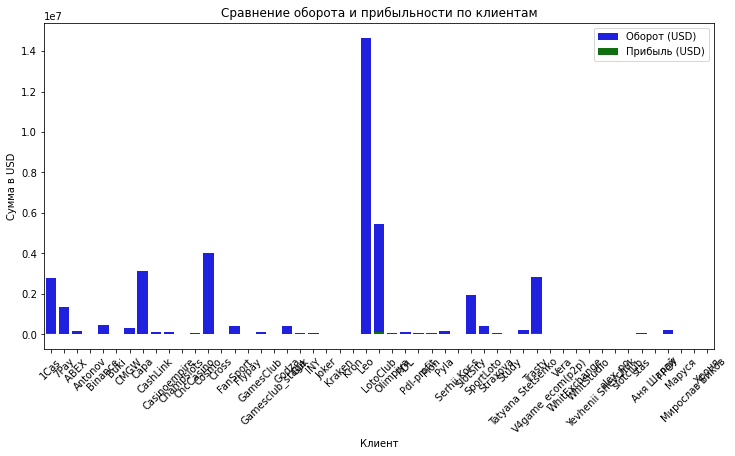

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Подготовка данных
client_data = new_df.groupby('client').agg({'turnover_in_usd': 'sum', 'profit_in_USD': 'sum'}).reset_index()

# Визуализация данных
plt.figure(figsize=(12, 6))

# Столбчатая диаграмма для оборота
sns.barplot(x='client', y='turnover_in_usd', data=client_data, color='blue', label='Оборот (USD)')

# Столбчатая диаграмма для прибыли, наложенная на диаграмму оборота
sns.barplot(x='client', y='profit_in_USD', data=client_data, color='green', label='Прибыль (USD)')

plt.title('Сравнение оборота и прибыльности по клиентам')
plt.xlabel('Клиент')
plt.ylabel('Сумма в USD')
plt.xticks(rotation=45)
plt.legend()
plt.show()
